In [1]:
import festim as F
import numpy as np
from festim2_solve_functions import *
from festim2_barrier_sweep_functions import *
from pathlib import Path
import csv

In [2]:
T = 600  # K
P_up_list = [0.1, 1, 10, 100, 1000, 10000, 100000] # Pa
barrier_thickness = 3e-3  # m
substrate_thickness = 3e-3  # m

results_folder = "results"
results_dir = Path(results_folder)  # convert str to Path
results_dir.mkdir(parents=True, exist_ok=True)
csv_path = results_dir / "sweep_varying_P_results.csv"

In [3]:
params_Wh_R1 = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e21,  # mol/m3Pa^0.5
    "E_S_barrier": 1,  # eV
    "K_r_0_barrier": 1e-18,  # m2/s Anderl 1992
    "E_K_r_barrier": 1,  # eV Anderl 1992
    "D_0_substrate": 1e-8,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1e21,  # mol/m3Pa^0.5
    "E_S_substrate": 1,  # eV
    "K_r_0_substrate": 1e-18,  # m2/s
    "E_K_r_substrate": 1,  # converting to eV from F. WAELBROECK et al
}

params_Wl_R1 = {
    "D_0_barrier": 1e-5,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e21,  # mol/m3Pa^0.5
    "E_S_barrier": 1,  # eV
    "K_r_0_barrier": 1e-18,  # m2/s Anderl 1992
    "E_K_r_barrier": 1,  # eV Anderl 1992
    "D_0_substrate": 1e-5,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1e21,  # mol/m3Pa^0.5
    "E_S_substrate": 1,  # eV
    "K_r_0_substrate": 1e-18,  # m2/s
    "E_K_r_substrate": 1,  # converting to eV from F. WAELBROECK et al
}

params_W1_Rl = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e21,  # mol/m3Pa^0.5
    "E_S_barrier": 1,  # eV
    "K_r_0_barrier": 1e-18,  # m2/s Anderl 1992
    "E_K_r_barrier": 1,  # eV Anderl 1992
    "D_0_substrate": 1e-8,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1e19,  # mol/m3Pa^0.5
    "E_S_substrate": 1,  # eV
    "K_r_0_substrate": 1e-18,  # m2/s
    "E_K_r_substrate": 1,  # converting to eV from F. WAELBROECK et al
}

params_W1_Rh = {
    "D_0_barrier": 1e-8,  # m2/s
    "E_D_barrier": 0.39,  # eV
    "S_0_barrier": 1e21,  # mol/m3Pa^0.5
    "E_S_barrier": 1,  # eV
    "K_r_0_barrier": 1e-18,  # m2/s Anderl 1992
    "E_K_r_barrier": 1,  # eV Anderl 1992
    "D_0_substrate": 1e-8,  # m2/s
    "E_D_substrate": 0.39,  # eV
    "S_0_substrate": 1e23,  # mol/m3Pa^0.5
    "E_S_substrate": 1,  # eV
    "K_r_0_substrate": 1e-18,  # m2/s
    "E_K_r_substrate": 1,  # converting to eV from F. WAELBROECK et al
}

param_list = [params_Wh_R1, params_Wl_R1, params_W1_Rl, params_W1_Rh]

In [4]:
need_header = not csv_path.exists()

with csv_path.open("w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    for i, params in enumerate(param_list, start=0):
        params = param_list[i]

        for j, P_up in enumerate(P_up_list, start=1):
            run_num = i * len(P_up_list) + j

            my_model = F.HydrogenTransportProblemDiscontinuous()

            create_mesh(my_model, barrier_thickness, substrate_thickness)

            barrier, substrate, left, right, H = assign_materials_and_domains(my_model, params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)

            my_model.settings = F.Settings(
                atol=1e-6,
                rtol=1e-10,
                transient=False,
            )

            barrier_export, substrate_export, flux_right = set_exports(my_model, barrier, substrate, left, right, H)

            my_model.initialise()
            my_model.run()

            C1 = barrier_export.data[0][0]  # concentration at the left side of the barrier
            Cm1 = barrier_export.data[0][-1]  # concentration at the right side of the barrier
            Cm2 = substrate_export.data[0][0]  # concentration at the left side of the substrate
            C2 = substrate_export.data[0][-1]  # concentration at the right side of the substrate
            W, R = compute_W_R(params, barrier_thickness, substrate_thickness, T=T, P_up=P_up)
            # print(flux_right.data)
            flux_right = flux_right.data

            row = {
                "run": run_num,
                "barrier_thickness": float(barrier_thickness),
                "substrate_thickness": float(substrate_thickness),
                "T": float(T),
                "P_up": float(P_up),
                "C1": C1,
                "Cm1": Cm1,
                "Cm2": Cm2,
                "C2": C2,
                "W": float(W),
                "R": float(R),
                "flux": float(flux_right[0]),
            }
            for k in param_keys:
                row[k] = float(params[k])

            with csv_path.open("a", newline="") as f:
                writer = csv.DictWriter(f, fieldnames=fieldnames)
                writer.writerow(row)

            if run_num % 100 == 0:
                print(f"Completed run {run_num} of {len(param_list)}")

    


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, Iterable, Optional
import csv
import math
from matplotlib.lines import Line2D


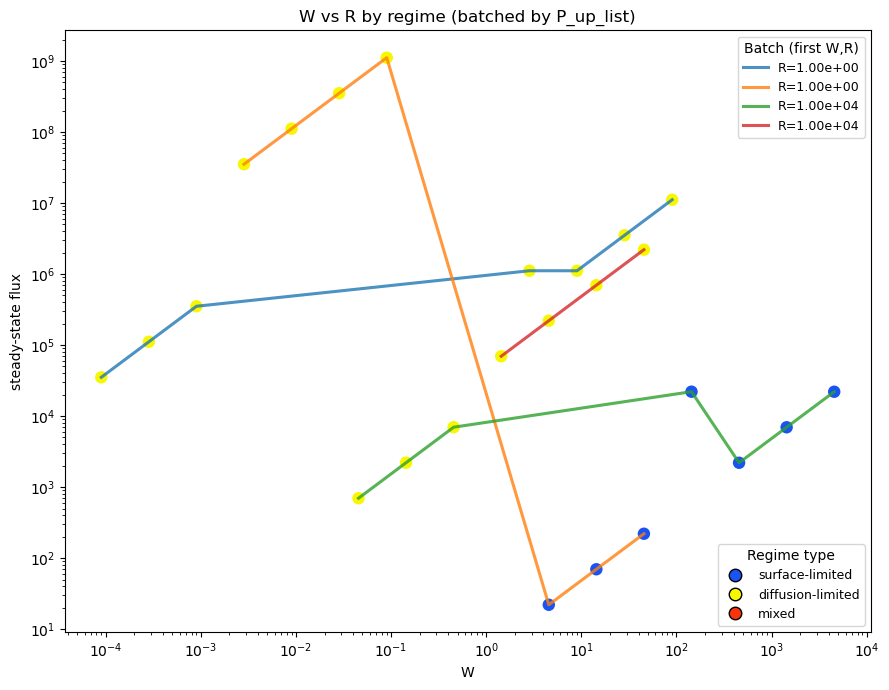

In [6]:
# simple helper
def _to_float(x):
    try:
        return float(x)
    except:
        return np.nan

# your determine_regime must be defined somewhere
# def determine_regime(...): ...

def plot_WR_batches(csv_file, n_pressures, skip_rows=2, regime_tol=1e-2):
    csv_file = Path(csv_file)

    # --- read CSV ---
    with csv_file.open("r", newline="") as f:
        reader = csv.DictReader(f)
        rows = list(reader)

    regimes = ["surface-limited", "diffusion-limited", "mixed"]
    regime_colors = {
        "surface-limited": "#1953f2",   # blue
        "diffusion-limited": "#f7f702", # yellow
        "mixed": "#f7340c",             # red
    }

    # line colors for batches
    line_cmap = plt.cm.get_cmap("tab10")
    plt.figure(figsize=(9, 7))

    i = skip_rows
    line_handles = []
    line_labels = []
    batch_index = 0

    while i < len(rows):
        group = rows[i : i + n_pressures]
        i += n_pressures

        W_vals, R_vals, flux_vals, reg_list = [], [], [], []

        for r in group:
            W = _to_float(r.get("W", "nan"))
            R = _to_float(r.get("R", "nan"))
            if not (np.isfinite(W) and np.isfinite(R) and W > 0 and R > 0):
                continue

            C1  = _to_float(r.get("C1", "nan"))
            Cm1 = _to_float(r.get("Cm1", "nan"))
            Cm2 = _to_float(r.get("Cm2", "nan"))
            C2  = _to_float(r.get("C2", "nan"))

            flux = _to_float(r.get("flux", "nan"))

            try:
                _, _, regime = determine_regime(C1, Cm1, Cm2, C2, tolerance=regime_tol)
            except:
                regime = "mixed"

            W_vals.append(W)
            R_vals.append(R)
            flux_vals.append(flux)
            reg_list.append(regime)

        # sort by W for cleaner lines
        idx = np.argsort(W_vals)
        W_vals = np.array(W_vals)[idx]
        R_vals = np.array(R_vals)[idx]
        reg_list = [reg_list[j] for j in idx]

        # assign unique color to this batch line
        line_color = line_cmap(batch_index % 10)
        batch_index += 1

        # label text for legend
        label = f"R={R_vals[0]:.2e}"

        # plot line (different color per batch)
        (line_handle,) = plt.plot(
            W_vals, flux_vals,
            color=line_color,
            lw=2.2,
            alpha=0.8,
            label=label
        )
        line_handles.append(line_handle)
        line_labels.append(label)

        # plot points with colors by regime
        for W, R, flux, reg in zip(W_vals, R_vals, flux_vals, reg_list):
            plt.scatter(W, flux, color=regime_colors.get(reg, "gray"), s=80, edgecolors="none")

    # --- build regime legend handles ---
    regime_handles = [
        Line2D([0], [0], marker="o", color="none", markerfacecolor=regime_colors[r],
               markersize=9, label=r)
        for r in regimes
    ]

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("W")
    plt.ylabel("steady-state flux")
    plt.title("W vs R by regime (batched by P_up_list)")

    # Legend 1: batch line info
    leg1 = plt.legend(line_handles, line_labels, title="Batch (first W,R)", loc="best", fontsize=9)
    plt.gca().add_artist(leg1)  # keep first legend when adding second

    # Legend 2: regime point colors
    plt.legend(handles=regime_handles, title="Regime type", loc="lower right", fontsize=9)

    plt.tight_layout()
    plt.show()

plot_WR_batches(csv_path, n_pressures=len(P_up_list))
